In [1]:
# Set relative path to parent directory
import sys, os
sys.path.insert(0, os.path.abspath('..'))

In [2]:
# Import environment
from environments.cartPendulum import cartPendulum

env = cartPendulum(mass_cart=1, mass_pendulum=0.1, length_pendulum=1, gravity=9.81)
env.step_size = 0.02

In [3]:
import sympy as sp
sp.init_printing()

# Create the symbolic variabels that we will use
m_c, m_p, l, theta, x, theta_dot, x_dot, u, g = sp.symbols('m_c m_p l theta x theta_dot x_dot u g')

# Compute mass and forcing matrix as given above
mass_matrix = sp.Matrix([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, m_c + m_p, m_p*l*sp.cos(theta)],[0, 0, sp.cos(theta), l]])
forcing_matrix = sp.Matrix([[x_dot], [theta_dot], [m_p*l*theta_dot*theta_dot*sp.sin(theta) + u], [g*sp.sin(theta)]])

In [6]:
# find f(x) as specified above
f = mass_matrix.inv()@forcing_matrix
f

⎡                                          x_dot                              
⎢                                                                             
⎢                                          θ_dot                              
⎢                                                                             
⎢                                                ⎛                2           
⎢  g⋅mₚ⋅sin(θ)⋅cos(θ)   ⎛          2           ⎞ ⎜          mₚ⋅cos (θ)        
⎢- ────────────────── + ⎝l⋅mₚ⋅θ_dot ⋅sin(θ) + u⎠⋅⎜────────────────────────────
⎢               2                                ⎜           ⎛            2   
⎢   m_c + mₚ⋅sin (θ)                             ⎝(m_c + mₚ)⋅⎝m_c + mₚ⋅sin (θ)
⎢                                                                             
⎢                                         ⎛          2           ⎞            
⎢                  g⋅(m_c + mₚ)⋅sin(θ)    ⎝l⋅mₚ⋅θ_dot ⋅sin(θ) + u⎠⋅cos(θ)     
⎢                  ──────────────────── - ──────────

In [129]:
# substitute in model parameters, and create a function model
parameters = {m_c: env.m_c, m_p: env.m_p, l: env.l, g: env.g}
dx = sp.utilities.lambdify((x, theta, x_dot, theta_dot, u), f.subs(parameters))

In [27]:
#fun = sp.utilities.lambdify([x, theta, x_dot, theta_dot, u], sp.Matrix([f.diff(x).T for x in [x, theta, x_dot, theta_dot, u]]))

In [224]:
# Generates G matrix given quadratic penaly Q and R
def gen_g(q, r, n):
    nx = np.shape(q)[0]
    nu = np.shape(r)[0]
    upper = np.concatenate((np.kron(np.identity(n), q), np.zeros([nx * n, nu * n])), axis=1)
    lower = np.concatenate((np.zeros([nu * n, nx * n]), np.kron(np.identity(n), r)), axis=1)
    return np.concatenate((upper, lower), axis=0)


import numpy as np
from scipy.integrate import odeint

# Define prediction horizon, number of states, number of inputs, and stepsize
N = 10
nx = 4
nu = 1
h = 0.1

# Weight matrix Q and R
Q = np.matrix([[1, 0, 0, 0], [0, 20, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]])
R = np.matrix([[1]])


# Define initial conditions
x0 = np.array([env.x]).T

# Compute the optimization problem matrices
G = gen_g(Q, R, N)

# Define objectve functions and constraint functions
fun = lambda x: (x.T@G@x)[0,0]
g_1 = lambda x: 2 - np.abs(x[0:nx*N:nx])

# Define helper functions
jac = lambda x: np.array(G@x)

def h_1(z):
    x = np.zeros((N, nx))
    u = np.zeros((N, nu))
    x[0, :] = x0.flatten()
    u[:, :] = np.reshape(z.flatten()[N*nx:], (N, nu))
    for t in range(0,N-1):
        f = lambda state, time: dx(*state, *u[t, :]).flatten()
        odeint(f, x[t, :].flatten(), [0, h])[1, :]
        x[t + 1, :] = odeint(f, x[t, :], [0, h])[1, :] #x[t, :] + h*dx(*x[t, :], *u[t, :]).flatten()
    return np.array(x.flatten() - z.flatten()[0:N*nx])

In [209]:
import scipy.optimize
def MPC(x0):
    res = scipy.optimize.minimize(fun = fun, 
                                  x0 = x0,
                                  method='SLSQP',
                                  jac = jac,
                                  constraints=({'type':'eq', 'fun':h_1}, {'type': 'ineq', 'fun': g_1}))
    u = res.x[4*N]
    return res.x ,u

In [ ]:
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib import animation
from IPython.display import HTML

# Simulate the environment for n_steps and save states in X
n_steps = 500
X = np.zeros((len(env.x), n_steps))
theta = (2*np.random.random() - 1)*0.4
state = env.init([0, np.pi, 0, 0])
U = np.zeros((n_steps))
x = np.zeros((nx*N + nu*N, 1))
for step in range(n_steps):
    X[:, step] = env.x
    x0 = env.x
    if step%10 == 0:
        x, u = MPC(x)
    U[step] = u
    state = env.step(u)

# Create the figure
fig = plt.figure()
ax = plt.axes(xlim=(-2, 2), ylim=(-1.1, 1.1), aspect='equal')
line, = ax.plot([], [], lw=2, marker='o', markersize=6)
rect = Rectangle([X[0][0] - 0.2, -0.1],0.4, 0.2, fill=True, color='red', ec='black')
ax.add_patch(rect)

animate = lambda i: (rect.set_xy([X[0,i] - 0.2, -0.1]), 
                     line.set_data([X[0,i], X[0,i] + np.sin(X[1, i])],[0, np.cos(X[1, i])]))

# Create and display animation
plt.close()
anim = animation.FuncAnimation(fig, animate, interval = env.step_size*1000, frames = n_steps)

In [214]:
HTML(anim.to_html5_video())

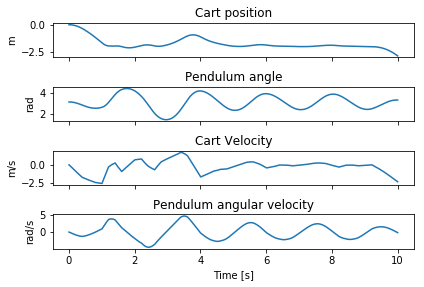

In [213]:
# Plot trajectory
#%matplotlib auto
t = np.linspace(0, n_steps*env.step_size, X.shape[1])
names = ["Cart position", "Pendulum angle", "Cart Velocity", "Pendulum angular velocity"]
units = ["m", "rad", "m/s", "rad/s"]
fig, axarr = plt.subplots(4, sharex=True)
for i in range(4):
    axarr[i].plot(t, X.T[:, i])
    axarr[i].title.set_text(names[i])
    axarr[i].set_ylabel(units[i])

fig.tight_layout()
fig.subplots_adjust(top=0.88)
plt.xlabel('Time [s]')
plt.show()